In [1]:
import psycopg2
# to install from commandline: conda install -c anaconda psycopg2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns

#need to be connected to vpn
import config 
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

In [2]:
# Models/algorithms/classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation of models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score


from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
#keep track of 1000 bootstraps
from tqdm.notebook import tqdm

#time counter
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

import matplotlib as mpl
#pretty
mpl.rcParams['pdf.fonttype'] = 42  # edit-able in illustrator
mpl.rcParams['font.sans-serif'] = 'Arial'
pd.set_option('display.max_columns', None)    

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.7 ms (started: 2022-07-27 09:25:33 -05:00)


In [38]:
death_id_oasis = pd.read_csv("death_id_oasis_ethnicity7-27-22.csv") 


time: 297 ms (started: 2022-07-27 12:03:10 -05:00)


In [21]:
Y=death_id_oasis['hospital_expire_flag']
columns_to_keep = [
    'age', 'preiculos','gcs','heartrate','meanbp',
    'resprate', 'temp',
       'urineoutput', 'mechvent', 'electivesurgery'
]
X = death_id_oasis[columns_to_keep]

time: 26.8 ms (started: 2022-07-27 09:30:15 -05:00)


/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:06:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


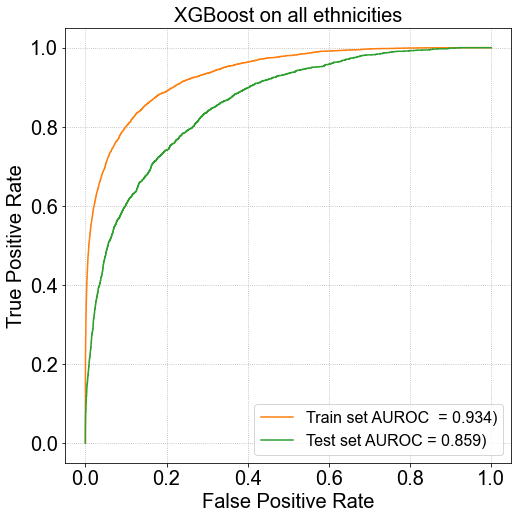

time: 2.85 s (started: 2022-07-27 10:06:53 -05:00)


In [32]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model on training data
model = XGBClassifier(use_label_encoder =False)
model.fit(X_train, Y_train)
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)
fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC  = "+str(round(auc2, 3))+")")
ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)
ax.set_title('XGBoost on all ethnicities', fontsize=20)

plt.show()

In [30]:
n_boot = 1000
auc_train = []
auc_test = []

time: 5.17 ms (started: 2022-07-27 09:42:31 -05:00)


In [36]:
for i in tqdm(range(n_boot)):
    # This line resamples the data, without replacement
    boot_segmented = death_id_oasis.sample(n=len(death_id_oasis), replace=False, axis=0)
    
    # Then the rest of the ML pipeline is done for the resampled data
    #split into training and test sets
    X_boot = boot_segmented[columns_to_keep].values
    Y_boot = boot_segmented['hospital_expire_flag'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X_boot, Y_boot, test_size=0.2, random_state=0)

    #train
    model_boot = XGBClassifier(use_label_encoder =False)
    model_boot.fit(X_train, Y_train, eval_metric='logloss')
    
    # Predictions
    Y_train_preds = model_boot.predict_proba(X_train)[:,1]
    Y_test_preds = model_boot.predict_proba(X_test)[:,1]
    
    # AUCs. Collected on lists.
    fpr, tpr, _ = roc_curve(Y_test.astype(int), Y_test_preds)
    auc1 = auc(fpr, tpr)
    auc_test.append(auc(fpr, tpr))
    fpr2, tpr2, _ = roc_curve(Y_train.astype(int), Y_train_preds)
    auc2 = auc(fpr2, tpr2)
    auc_train.append(auc(fpr2, tpr2))



  0%|          | 0/1000 [00:00<?, ?it/s]

time: 49min 7s (started: 2022-07-27 10:10:16 -05:00)


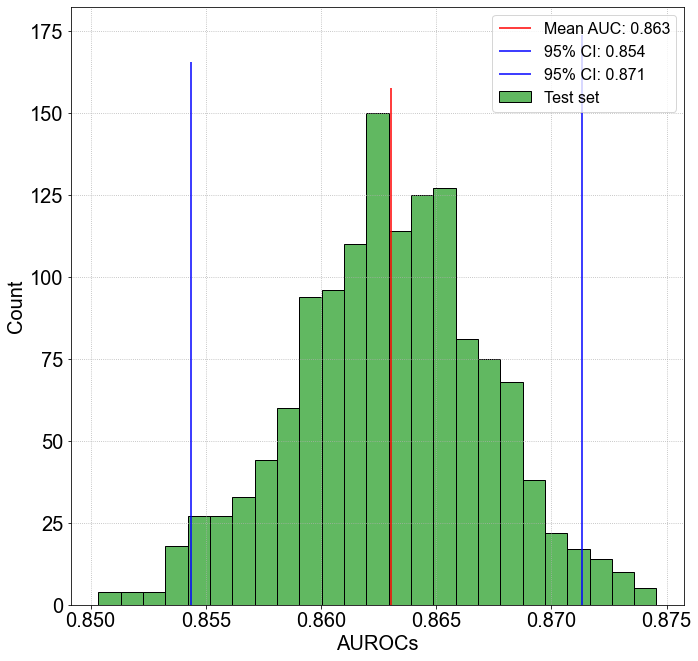

time: 293 ms (started: 2022-07-27 11:59:28 -05:00)


In [37]:

fig1, ax1 = plt.subplots(1,1, figsize=(11,11))
# sns.histplot(auc_train, stat='count', color='C1', ax=ax1, label='Train set')
sns.histplot(auc_test, stat='count', color='C2', ax=ax1, label='Test set')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_xlabel('AUROCs', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# ax1.vlines(np.mean(auc_train), 0, ax1.get_ylim()[-1],
#                 color='r', label=f"Mean AUC: {np.mean(auc_train):.3f}")

# ax1.vlines(np.percentile(auc_train, 2.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 2.5):.3f}")

# ax1.vlines(np.percentile(auc_train, 97.5), 0, ax1.get_ylim()[-1],
#                 color='b', label=f"95% CI: {np.percentile(auc_train, 97.5):.3f}")

ax1.vlines(np.mean(auc_test), 0, ax1.get_ylim()[-1],
                color='r', label=f"Mean AUC: {np.mean(auc_test):.3f}")

ax1.vlines(np.percentile(auc_test, 2.5), 0, ax1.get_ylim()[-1],
                color='b', label=f"95% CI: {np.percentile(auc_test, 2.5):.3f}")

ax1.vlines(np.percentile(auc_test, 97.5), 0, ax1.get_ylim()[-1],
                color='b',label=f"95% CI: {np.percentile(auc_test, 97.5):.3f}")

ax1.grid(linestyle=':')
ax1.legend(loc='best', fontsize=16)

plt.show()

In [115]:
y_true = Y_test
y_pred = Y_test_preds
y_true2 = y_true.to_numpy()
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
y_true2 = y_true.to_numpy()
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true2[indices], y_pred[indices])
    bootstrapped_scores.append(score)

(array([  1.,  10.,  37., 120., 198., 282., 215.,  92.,  41.,   4.]),
 array([0.84192601, 0.84512674, 0.84832747, 0.8515282 , 0.85472894,
        0.85792967, 0.8611304 , 0.86433113, 0.86753186, 0.8707326 ,
        0.87393333]),
 <BarContainer object of 10 artists>)

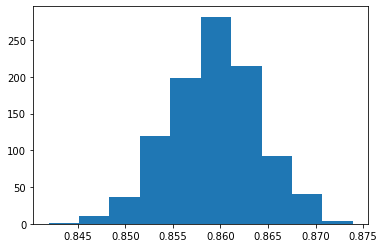

In [125]:
plt.hist(bootstrapped_scores)

In [127]:
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.2f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.95 confidence interval 0.850% and 0.868%


In [128]:
#all together

y_true = Y_test.to_numpy()
y_pred = Y_test_preds

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(bootstrapped_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(bootstrapped_scores, p))
print('%.3f confidence interval %.3f%% and %.3f%%' % (alpha, lower, upper))

0.950 confidence interval 0.850% and 0.868%
